The goal of this notebook is to explore how markers can be used to guide the algorithm finding the optimal window within a marker range. This is also useful for looking at marker ranges across an entire graph

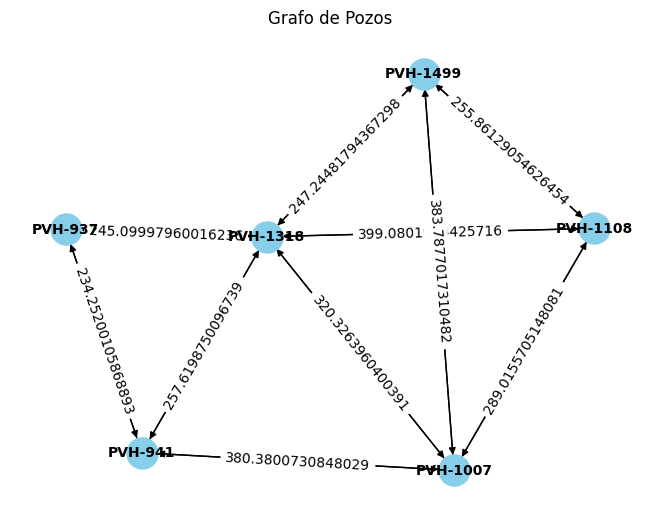

In [1]:
import numpy as np
import pandas as pd
from graph_setup import G
from marker_functions import mkr_calc_window
from calc_functions import windows_test
from marker_functions import create_subs
import matplotlib.pyplot as plt

In [2]:
marker_ranges = mkr_calc_window(G, "PVH-937", "PVH-941")
print(marker_ranges)

Calculating windows for marker range 0 - K
100%|██████████| 50/50 [00:15<00:00,  3.25trial/s, best loss: 1.4624999999999773]
Optimal windows: [874.0, 1078.5, 870.5, 1070.5]
Minimum error: 1.4624999999999773
Calculating windows for marker range K - L2
100%|██████████| 50/50 [00:21<00:00,  2.28trial/s, best loss: 1.2930555555555605]
Optimal windows: [1077.5, 1290.5, 1077.5, 1290.5]
Minimum error: 1.2930555555555605
Calculating windows for marker range L2 - inf
100%|██████████| 50/50 [01:00<00:00,  1.21s/trial, best loss: 71.14159090909092]
Optimal windows: [1294.0, 1985.5, 1290.5, 1617.5]
Minimum error: 71.14159090909092
      Label           Range PVH-937           Range PVH-941   Opt Win PVH-937  \
0     0 - K          (0, 1075.1807)          (0, 1073.5878)   (874.0, 1078.5)   
1    K - L2  (1075.1807, 1290.3693)  (1073.5878, 1290.3293)  (1077.5, 1290.5)   
2  L2 - inf        (1290.3693, inf)        (1290.3293, inf)  (1294.0, 1985.5)   

    Opt Win PVH-941      Error  
0   (870.5, 107

In [13]:
graph_markers = pd.DataFrame(columns=["Mkr"])
unique_markers = set()
for node in G.nodes:
    #graph_markers["Mkr"] = 0
    mk = G.nodes[node]["markers"]

    for marker_name in mk["Mkr"]:
        unique_markers.add(marker_name)

    graph_markers.drop(columns="Mkr")
    graph_markers["Mkr"] = np.array(mk.shape[0])
    graph_markers["Mkr"] = [n for n in unique_markers]
    print(graph_markers)
    
    #graph_markers[node] = mk[mk["Mkr"]==graph_markers["Mkr"]]["Depth"]


print(graph_markers)

  Mkr
0   K
1   C
2  L2


ValueError: Length of values (4) does not match length of index (3)

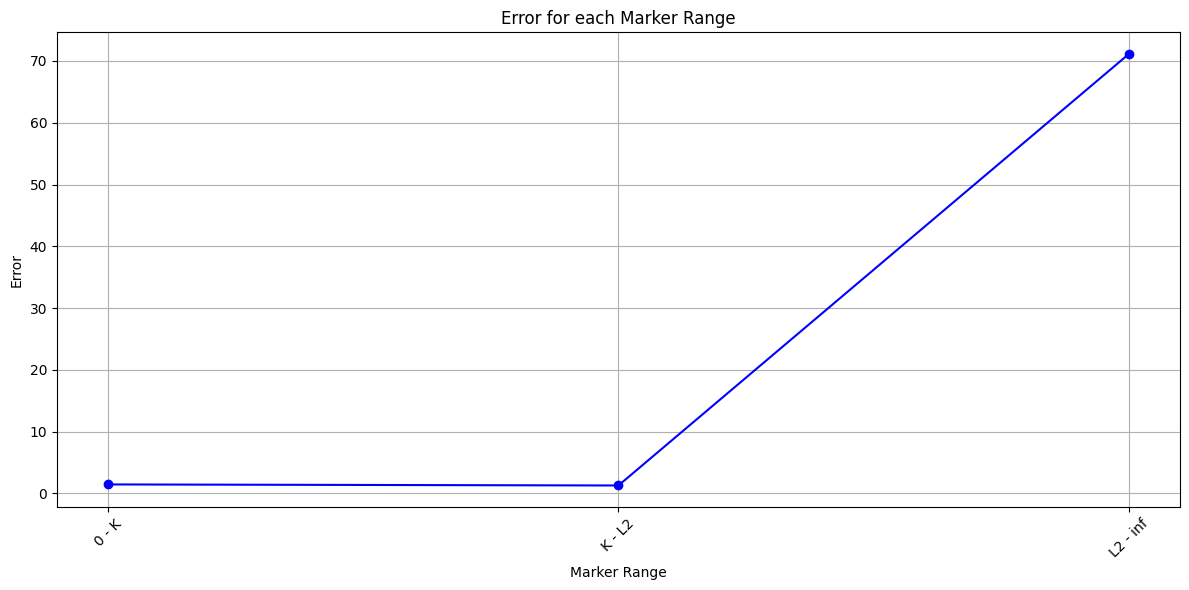

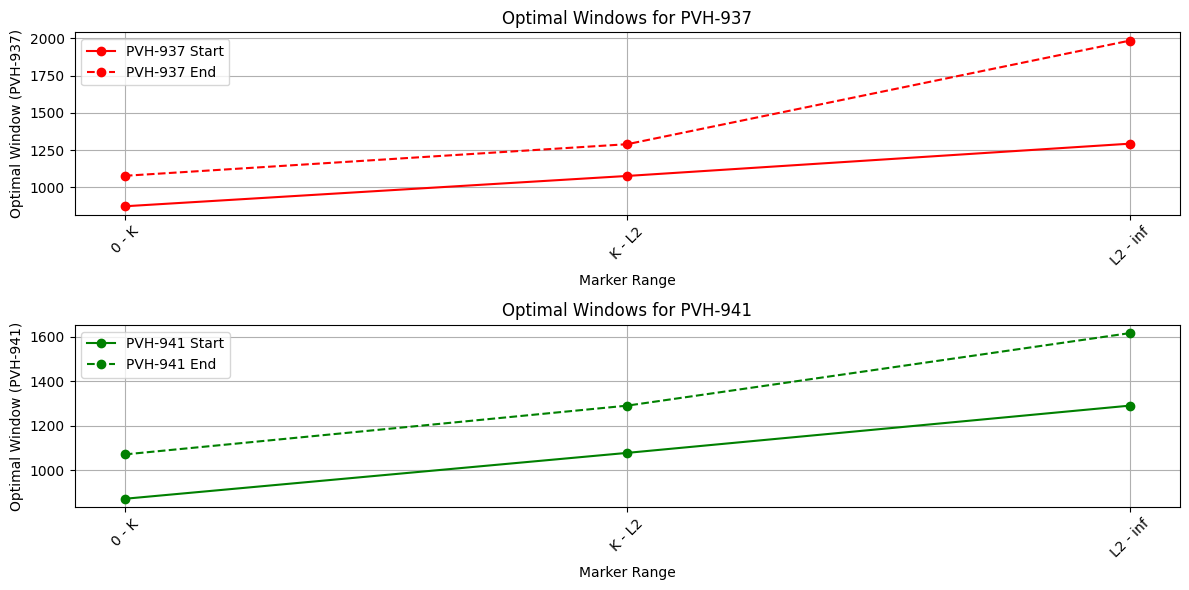

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(marker_ranges["Label"], marker_ranges["Error"], marker='o', linestyle='-', color='b')
plt.xlabel('Marker Range')
plt.ylabel('Error')
plt.title('Error for each Marker Range')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

node_name1 = "PVH-937"
node_name2 = "PVH-941"

# Plotting the Optimal Windows for each node
plt.figure(figsize=(12, 6))
# Node 1
plt.subplot(2, 1, 1)
plt.plot(marker_ranges["Label"], marker_ranges[f"Opt Win {node_name1}"].apply(lambda x: x[0]), marker='o', linestyle='-', color='r', label=f'{node_name1} Start')
plt.plot(marker_ranges["Label"], marker_ranges[f"Opt Win {node_name1}"].apply(lambda x: x[1]), marker='o', linestyle='--', color='r', label=f'{node_name1} End')
plt.xlabel('Marker Range')
plt.ylabel(f'Optimal Window ({node_name1})')
plt.title(f'Optimal Windows for {node_name1}')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()

# Node 2
plt.subplot(2, 1, 2)
plt.plot(marker_ranges["Label"], marker_ranges[f"Opt Win {node_name2}"].apply(lambda x: x[0]), marker='o', linestyle='-', color='g', label=f'{node_name2} Start')
plt.plot(marker_ranges["Label"], marker_ranges[f"Opt Win {node_name2}"].apply(lambda x: x[1]), marker='o', linestyle='--', color='g', label=f'{node_name2} End')
plt.xlabel('Marker Range')
plt.ylabel(f'Optimal Window ({node_name2})')
plt.title(f'Optimal Windows for {node_name2}')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()